As ever, we need to:

    export   PYTHONPATH="../tools:../:../tools/packages/lib/python/:../tools/tomocorr:/Users/earawa/Code/SHTOOLS"
    
before starting

In [1]:
# Environment setup - quite a lot here

# Make pictures show up in the web browser,
# import matplotlib etc, and make the figures
# big
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as basemap
plt.rcParams['figure.figsize'] = (12, 8)

# Other "standard" modules
import itertools
import pandas
import numpy as np
import scipy.optimize as spo

import pyshtools as shtools

import obspy.taup

Loading SHTOOLS documentation


## First we need to find how the travel time changes with CMB radius

This is based on Andy's code. We ought to subclass tauPyModel and add a perturb_cmb method...

In [2]:
def get_iasp91_cmb_perturbed_model(dc):
    """
    Return a perturbed version of the inbuilt iasp91 model, where the CMB is shifted
    up or down by dc km.  Positive values shift the CMB up, and squash the bottom layer in
    iasp91 so that the velocity at the CMB is the same when the CMB is perturbed.
    Arguments:
        dc : Perturbation to the CMB depth / km.  Positive dc is towards the surface.
    Returns a TauPyModel instance.
    """
    import os
    import glob
    import sys
    from obspy.taup.taup_create import __DATA_DIR
    # Find inbuilt model file for iasp91, called iasp91.tvel
    tvel_files = glob.glob(os.path.join(__DATA_DIR, "iasp91.tvel"))
    if len(tvel_files) != 1:
        sys.stdout.write("get_iasp91_cmb_perturbed_model: Error: Cannot find iasp91.tvel file")
        sys.exit(1)
    file = tvel_files[0]
    # Create velocity model from this
    model = obspy.taup.velocity_model.VelocityModel.readVelocityFile(file)
    # Perturb bottom layer
    icmb = model.layerNumberAbove(model.cmbDepth)[0]
    model.layers[icmb][1] -= dc
    model.layers[icmb+1][0] -= dc
    # Create slowness model from velocity model
    smodel = obspy.taup.slowness_model.SlownessModel(model)
    # Create tau-p model from slowness model
    tpmodel = obspy.taup.tau_model.TauModel(smodel)
    # Create new instance of TauPyModel class, and replace it with the perturbed one
    m = obspy.taup.TauPyModel()
    m.model = tpmodel
    return m

In [3]:
iasp91 = obspy.taup.TauPyModel("iasp91")
                            # Event parameters
depth = 100. # This makes no difference for us
distances = np.array([30., 55., 80.])
    
nd = len(distances)
dcs = np.arange(-20., 21., 5.)
ndc = len(dcs)
# Array holding the traveltimes, with dimensions (distance, dc)
dt = np.zeros([nd, ndc])

# For fitting
x = []
y = []
z = []

for idc in range(ndc):
    dc = dcs[idc]
    # Create model for this deflection
    m = get_iasp91_cmb_perturbed_model(dc)
    for idist, dist in enumerate(distances):
        arr_iasp91 = iasp91.get_travel_times(depth, dist, phase_list=['P', 'PcP'])
        arr = m.get_travel_times(depth, dist, phase_list=['P', 'PcP'])
        dt[idist,idc] = arr[-1].time - arr_iasp91[-1].time
        x.append(dist)
        y.append(dc)
        z.append(dt[idist,idc])
        

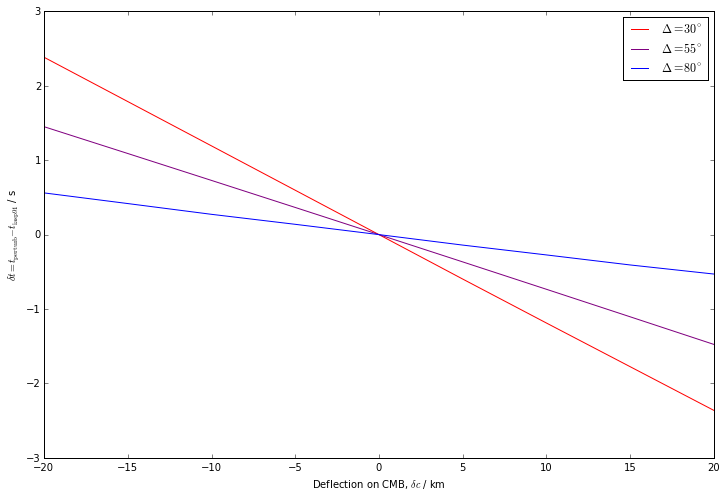

In [4]:
dt_30deg = dt[0,:]
dt_55deg = dt[1,:]
dt_80deg = dt[2,:]
p = plt.plot(dcs, dt_30deg, color='red', label=r"$\Delta = 30^\circ$")
p = plt.plot(dcs, dt_55deg, color='purple', label=r"$\Delta = 55^\circ$")
p = plt.plot(dcs, dt_80deg, color='blue', label=r"$\Delta = 80^\circ$")
plt.xlabel(r"Deflection on CMB, $\delta c$ / km")
plt.ylabel(r"$\delta t = t_\mathrm{perturb} - t_\mathrm{iasp91}$ / s")
plt.legend()
plt.show()

In [5]:
#  Need to fit the results... use low order polynomial - 
# see http://stackoverflow.com/questions/7997152/python-3d-polynomial-surface-fit-order-dependent

def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z

x = np.array(x)
y = np.array(y)
z = np.array(z)
m = polyfit2d(x, y, z, order=2)



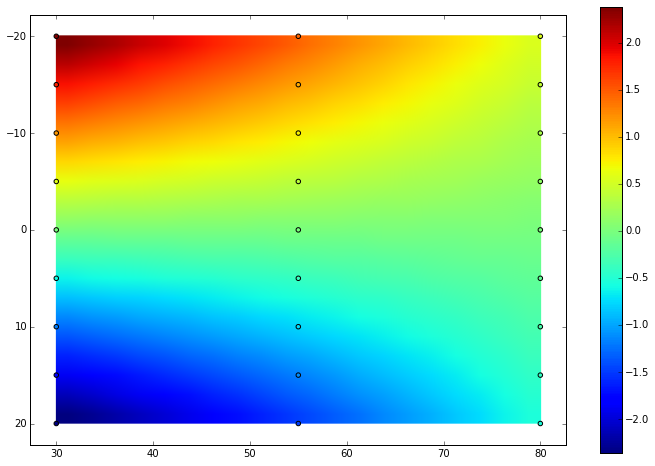

In [6]:
# Evaluate it on a grid...
nx, ny = 20, 20
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), nx), 
                     np.linspace(y.min(), y.max(), ny))
zz = polyval2d(xx, yy, m)

# Plot
plt.imshow(zz, extent=(x.min(), x.max(), y.max(), y.min()))
plt.scatter(x, y, c=z)
plt.colorbar()
plt.show()

In [7]:
# And we can fit our data with, e.g.
distance = 40.0
cmb_displacment = -5.0
dt = polyval2d(distance, cmb_displacment, m)
print "dt = ", dt

dt =  0.502416870078


In [8]:
def get_disp(dt, dist, m):

    def misfit(dcmb):
        mis = np.absolute(polyval2d(dist, dcmb[0], m) - dt)
        return mis
    
    dcmb = spo.fmin(misfit, 0.0, disp=0)
    # Test that it worked...
    return dcmb[0]
    
print "dt = ", get_disp(0.502416870078, 40.0, m), " km"

dt =  -5.0  km


## We now need our data

In [9]:
# Read data we have previously saved
paired_picks_df = pandas.read_pickle('processed_data.pkl')

In [10]:
paired_picks_df

,eventid,P_datetime,station_lon,reporter,PcP_datetime,epicentral_distance,station_elev,event_lat,station,backazimuth,...,PcP_P_dtime_resid,azimuth,P_ellip_corr,PcP_ellip_corr,P_tomo_corr,PcP_tomo_corr,P_ttime_corrected,PcP_ttime_corrected,PcP_P_dtime_corrected,PcP_P_dtime_corrected_resid
600130102GTABJI,600130102,2012-01-01 00:38:39.200,99.8144,BJI,2012-01-01 00:40:10.900,47.42,1341.0,11.9775,GTA,313.2,...,1.633292,-46.797752,0.190548,0.251167,-0.028364,-0.650772,512.162183,603.300395,91.138212,1.071503
600130102GYABJI,600130102,2012-01-01 00:37:21.200,106.6640,BJI,2012-01-01 00:39:38.700,37.67,1162.0,11.9775,GYA,297.9,...,0.724390,-62.053108,0.333250,0.496174,0.744649,0.072260,435.077898,572.068434,136.990535,0.214926
600130102KLRIDC,600130102,2012-01-01 00:37:25.400,131.7500,IDC,2012-01-01 00:39:39.170,38.44,298.0,11.9775,KLR,347.4,...,1.066239,-12.607231,-0.025985,-0.008143,-0.297828,-0.263379,437.876187,571.698478,133.822291,1.118531
600130102KSHBJI,600130102,2012-01-01 00:40:50.000,75.9731,BJI,2012-01-01 00:41:23.300,65.33,1314.0,11.9775,KSH,308.0,...,1.446821,-51.901723,0.270470,0.302495,0.823228,0.043098,643.893698,676.445593,32.551894,0.698715
600130102PETKIDC,600130102,2012-01-01 00:38:00.270,157.6989,IDC,2012-01-01 00:39:51.750,42.53,400.0,11.9775,PETK,12.5,...,-0.616608,12.438778,-0.077400,-0.085894,-0.340405,-0.634233,472.652194,583.829873,111.177679,-0.918929
600130102SONMIDC,600130102,2012-01-01 00:38:39.360,106.3950,IDC,2012-01-01 00:40:09.380,47.41,1415.8,11.9775,SONM,326.3,...,-0.089276,-33.652428,0.035502,0.053855,-0.076805,-0.707003,512.118697,601.526852,89.408154,-0.701122
600130102ZALVIDC,600130102,2012-01-01 00:40:26.100,84.8188,IDC,2012-01-01 00:41:05.750,62.28,229.4,11.9775,ZALV,325.1,...,0.187496,-34.807830,-0.035518,-0.037878,-0.479296,-1.061472,618.385186,657.450650,39.065463,-0.397041
600130103AS01NEIC,600130103,2012-01-01 00:56:35.790,133.9510,NEIC,2012-01-01 00:59:19.090,33.03,605.0,-11.3505,AS01,243.9,...,0.509122,-116.127778,0.331128,0.535642,-0.910794,0.067090,390.370334,554.852733,164.482399,1.691521
600130103ASARIDC,600130103,2012-01-01 00:56:36.100,133.9040,IDC,2012-01-01 00:59:19.400,33.07,607.0,-11.3505,ASAR,243.9,...,0.745419,-116.108842,0.331425,0.535699,-0.915006,0.064931,390.676419,555.160631,164.484211,1.929630
600130103STKAIDC,600130103,2012-01-01 00:56:15.400,141.5952,IDC,2012-01-01 00:59:13.370,30.55,272.3,-11.3505,STKA,224.2,...,0.126916,-135.793508,0.207177,0.373697,0.228420,0.176501,370.995597,549.080198,178.084601,0.241518


In [11]:
# Now we need to convert the PcP-P residual into a CMB deflection
# Using the parameterisation derviced above

paired_picks_df["dCMB"] = paired_picks_df.apply(
    lambda row: get_disp(row['PcP_P_dtime_corrected_resid'], 
                         row['epicentral_distance'], m), axis=1)



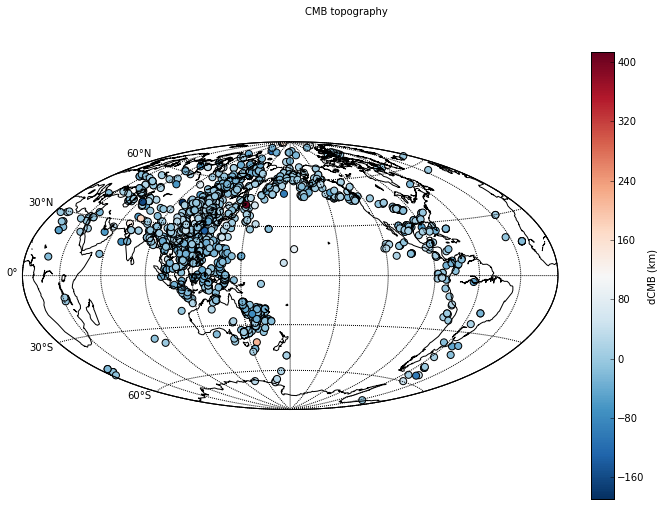

In [12]:
fig = plt.figure()
axis = fig.add_subplot(1,1,1)
map = basemap.Basemap(projection='hammer',
                      lat_0=0.0, lon_0=180.0, resolution='c', ax=axis)

map.drawcoastlines()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30), labels=[1,0,0,0])

# we need to find the x, y position of the data given
# the map projection.
lonp, latp = map(
    paired_picks_df.CMB_bounce_lon.values, 
    paired_picks_df.CMB_bounce_lat.values)

# plot the data - colour by epicentral distance
sc = map.scatter(lonp, latp, 
                 c=(paired_picks_df.dCMB), 
                 cmap=plt.cm.RdBu_r, s=50)

cb = plt.colorbar(sc)
cb.ax.set_ylabel('dCMB (km)')
fig.suptitle('CMB topography')
plt.show()

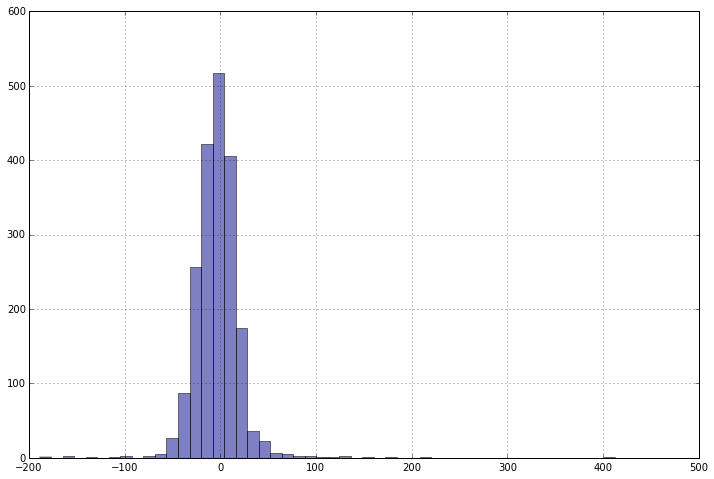

In [13]:
ax = paired_picks_df.dCMB.hist(bins=50, color='DarkBlue', alpha=0.5)

## Fit a smooth model of CMB topography
This is based on spherical harmonics to degree 4 would be nice
... but we can only go to degree 2 with this data

In [14]:
# Find the spherical harmonic coefficents up to degree 2
# Arguments are value, long, lat...
cilm, chi2 = shtools.SHExpandLSQ(paired_picks_df.dCMB.values, 
                                 paired_picks_df.CMB_bounce_lon.values,
                                 paired_picks_df.CMB_bounce_lat.values, 2)

In [15]:
# Evaluate on a 1-degree by 1-degree grid for plotting
lats, lons = np.meshgrid(np.arange(-90.0, 91.0, 1.0), np.arange(0.0, 361.0, 1.0))
dcmb_smooth = np.zeros_like(lats)
for i in range(np.arange(-90.0, 91.0, 1.0).size):
    for j in range(np.arange(0.0, 361.0, 1.0).size):        
        dcmb_smooth[j,i] = shtools.MakeGridPoint(cilm, lats[j,i], lons[j,i])

//anaconda/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


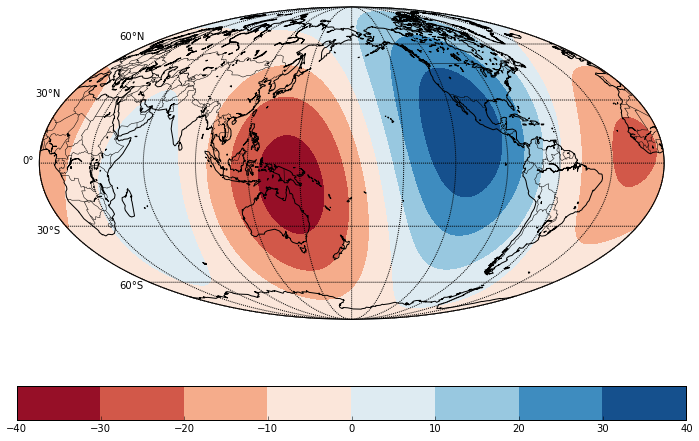

In [16]:
fig = plt.figure()
axis = fig.add_subplot(1,1,1)

map = basemap.Basemap(projection='moll', lon_0=180.0,
                  resolution='c', area_thresh=1000., ax=axis)
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()
map.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,0])
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])

# convert lat and lon to map ref. system
lon_m, lat_m = map(lons.flatten(), lats.flatten())

conts = map.contourf(lon_m, lat_m, dcmb_smooth.flatten(), tri=True, cmap=plt.cm.RdBu,)
fig.colorbar(conts, ax=axis, orientation='horizontal')

plt.show()